Gymnasium's Pusher task : SAC Torchrl torial

In [1]:
!pip3 install torchrl
!pip3 install gymnasium[mujoco]
!pip3 install tqdm

In [2]:
# Torch
import torch
from tensordict.nn import TensorDictModule, InteractionType
from tensordict.nn.distributions import NormalParamExtractor

# Tensordict modules
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs.libs.gym import GymEnv
import gymnasium, gym
from torchrl.envs.utils import check_env_specs

# Model and policy
from torchrl.modules import MLP, ProbabilisticActor, TanhNormal, ValueOperator
# Loss
from torchrl.objectives import SoftUpdate
from torchrl.objectives.sac import SACLoss

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

In [3]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
gym_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 10  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 20  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-5  # Learning rate

# SAC
value_loss='l2' # 'smooth_l1' 'l2'; loss function to be used with the value function loss
gamma = 0.9  # discount factor
polyak = 0.995 # lambda for generalised advantage estimation

# Model
layers_config = [256, 64, 32]  # Number of units per layer in the network

# GYM
scenario_name = "Pusher-v4"
max_steps = 200

env = GymEnv(
    env_name=scenario_name,
    device=gym_device,
)

check_env_specs(env)

time = time.time()
print(time)

/home/codespace/.python/current/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
2024-02-25 17:25:45,979 [torchrl][INFO] check_env_specs succeeded!


1708881945.980131


In [4]:
print("observation_space", env.observation_space)
print("action_space", env.action_space)
print("observation size", env.observation_space.shape[0])

observation_space Box(-inf, inf, (23,), float64)
action_space Box(-2.0, 2.0, (7,), float32)
observation size 23


In [5]:
def make_policy_module(env, layers_config, device):
    policy_net = MLP(
        in_features=env.observation_space.shape[0],
        out_features=env.action_space.shape[0] * 2,  # 2 outputs per action: loc and scale
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,
    )

    seq_policy_net = torch.nn.Sequential(
        policy_net,
        NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
    )

    policy_module = TensorDictModule(
        seq_policy_net,
        in_keys=["observation"],
        out_keys=["loc", "scale"],
    )

    policy = ProbabilisticActor(
        module=policy_module,
        in_keys=["loc", "scale"],
        out_keys=["action"],
        spec=env.action_spec,
        distribution_class=TanhNormal,
        distribution_kwargs={
            "min": env.action_spec.space.minimum,
            "max": env.action_spec.space.maximum,
            "tanh_loc": False,
        },
        default_interaction_type=InteractionType.RANDOM,
        return_log_prob=False,
    )

    return policy

def make_Qval_module(env, layers_config, device):
    Qval_net = MLP(
        in_features=env.observation_space.shape[0] + env.action_space.shape[0],
        out_features=1,  # 2 outputs per action: loc and scale
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,
    )

    Qval = ValueOperator(
        module=Qval_net,
        in_keys=["observation", "action"],
    )

    return Qval

In [6]:
def make_collector(env, policy, device, storing_device, frames_per_batch, init_random_frames, total_frames, max_steps_per_traj=1000):
    return SyncDataCollector(
        env,
        policy,
        device=device,
        storing_device=storing_device,
        frames_per_batch=frames_per_batch,
        init_random_frames=init_random_frames,
        total_frames=total_frames,
        max_frames_per_traj=max_steps_per_traj,
        
    )

def make_replay_buffer(frames_per_batch, minibatch_size, device):
    return ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,  # We will sample minibatches of this size
    )

In [7]:
def make_loss_module(env, policy, Qval, value_loss, gamma, polyak, lr):
    loss_module = SACLoss(
        actor_network=policy,
        qvalue_network=Qval,
        loss_function=value_loss,
        action_spec=env.action_spec,
    )
    loss_module.make_value_estimator(gamma=gamma)
    target_net_updater = SoftUpdate(loss_module,
                                    eps=polyak)
    optim = torch.optim.Adam(loss_module.parameters(),
                             lr=lr)
    
    return loss_module, target_net_updater, optim

In [8]:
def training_loop(
    env,
    loss_module,
    target_net_updater,
    optim,
    collector,
    replay_buffer,
    n_iters,
    num_epochs,
    frames_per_batch,
    minibatch_size):

    rewards = []
    rewards_eval = []

    # Main loop
    pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

    q_loss = None

    episode_reward_mean_list = []

    for tensordict_data in collector:
        # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)
        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
        replay_buffer.extend(data_view)

        for _ in range(num_epochs):
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffer.sample()

                loss_vals = loss_module(subdata)

                loss_value = (
                    loss_vals["loss_actor"]
                    + loss_vals["loss_qvalue"]
                    + loss_vals["loss_alpha"]
                )

                optim.zero_grad()
                loss_value.backward()
                optim.step()

                # update qnet_target params
                target_net_updater.step()

        # update weights of the inference policy
        collector.update_policy_weights_()

        # Logging
        done = tensordict_data.get(("next", "done"))
        episode_reward_mean = (
            tensordict_data.get(("next", "reward"))[done].mean().item()
        )
        episode_reward_mean_list.append(episode_reward_mean)
        pbar.set_description(f"episode_reward_mean = {round(episode_reward_mean, 4)}", refresh=False)
        pbar.update()

    pbar.close()
    collector.shutdown()
    replay_buffer.empty()
    
    return episode_reward_mean_list

In [9]:
policy = make_policy_module(env, layers_config, device)
Qval = make_Qval_module(env, layers_config, device)
collector = make_collector(env, policy, device, device, frames_per_batch, init_random_frames=0, total_frames=total_frames, max_steps_per_traj=max_steps)
replay_buffer = make_replay_buffer(frames_per_batch, minibatch_size, device)
loss_module, target_net_updater, optim = make_loss_module(env, policy, Qval, value_loss, gamma, polyak, lr)
episode_reward_mean_list = training_loop(env, loss_module, target_net_updater, optim, collector, replay_buffer, n_iters, num_epochs, frames_per_batch, minibatch_size)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

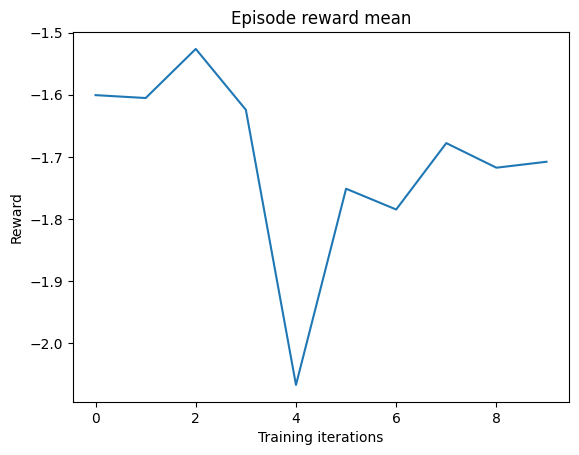

In [ ]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.savefig('Episode reward mean', format='png')
plt.show()